In [1]:
import torch
import numpy as np
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from IPython.display import clear_output as co
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim import Adam
import seaborn as sns
from PIL import Image
from glob import glob
sns.set_theme(style="darkgrid", font_scale = 0.7)

try:
    from dotenv import load_dotenv
    load_dotenv()
except:
    print('.env is not loaded')
    pass

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from teleflow import Bot
bot = Bot()

In [2]:
def _load(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('L')

class Faces(Dataset):
    def __init__(self, root, split = 'train', transform = None, download = False):
        if download:
            self._download()
        
        self.root = os.path.join('faces_dataset', root, split)
        self.names, self.name2id, self.id2name = self._get_names()
        self.images, self.labels = self._get_people()
        self.total_idxs = np.arange(len(self.images))
        self.transform = transform



    def _get_names(self):
        names = list(map(lambda x : int(x), os.listdir(self.root)))
        name2id = {name : _ for _, name in enumerate(names)}
        id2name = {_ : name for _, name in enumerate(names)}
 
        return names, name2id, id2name
    
    def _get_people(self):
        images = glob(os.path.join(self.root, '*\\*'))
        labels = [self.name2id[int(image.split('\\')[-2])] for image in images]
        return np.array(images), np.array(labels)
    
    def _download(self):
        import gdown
        import zipfile
        import os
        file_id = '1S6Wqm9CoLgVVWe8kPIbBseS_ndGTIR-V'
        output = 'faces_dataset.zip'
        gdown.download(f'https://drive.google.com/uc?id={file_id}', output)
        with zipfile.ZipFile(output, 'r') as zip_ref:
            zip_ref.extractall('faces_dataset')
        os.remove(output)
        print('Загрузка датасета произошла успешно бип-буп-буп')
            

    def __getitem__(self, index):
        image1 = _load(self.images[index])

        if np.random.uniform() < 0.5:
            image2 = _load(np.random.choice(self.images[self.labels == self.labels[index]]))
            label = torch.tensor([1], dtype = torch.float)
        else:
            image2 = _load(np.random.choice(self.images[self.labels != self.labels[index]]))
            label = torch.tensor([0], dtype = torch.float)
        
        if self.transform is not None:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        
        return image1, image2, label, torch.tensor(self.labels[index], dtype = torch.int)
    
    def __len__(self):
        return len(self.images)

faces = Faces(root = 'faces_dataset', download = True)

In [3]:
train_transform = T.Compose([
    T.Resize((128, 128)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
])
test_trainform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
])

train_set = Faces(root = 'faces_dataset', split = 'train', transform = train_transform)
test_set = Faces(root = 'faces_dataset', split = 'test', transform = test_trainform)

train_loader = DataLoader(train_set, batch_size =32, shuffle = True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size = 32, shuffle = False, num_workers=0, pin_memory=True)

In [4]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin = 2.0):
        super().__init__()
        self.margin = margin
    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        return torch.mean(label * torch.pow(euclidean_distance, 2) + (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min = 0.0), 2))

class ContrativeModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.feature_ex = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
        )
        self.fc = nn.Sequential(
            nn.Linear(16 * 16 * 32, 512),
            nn.ELU(),
            nn.Linear(512, 10),
        )

    def forward_single(self, x):
        return self.fc(self.feature_ex(x))
        
    def forward(self, x1, x2):
        return self.forward_single(x1), self.forward_single(x2)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'; print(device)

cuda


In [8]:
def train(model, loader, optim, loss_fn):
    model.train()
    train_loss = 0
    for x1, x2, y, _ in tqdm(loader, desc = "Train"):
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        optim.zero_grad()
        y_pred1, y_pred2 = model(x1, x2)
        loss = loss_fn(y_pred1, y_pred2, y)
        train_loss += loss.item()
        loss.backward()
        optim.step()
    return train_loss / len(loader)
@torch.inference_mode()
def get_latent_base(model):
    model.eval()
    xs = []
    ys = []
    zs = []

    for x, _, _, y in train_loader:
        z = model.forward_single(x.to(device))
        xs.append(x)
        ys.append(y)
        zs.append(z)
    xs = torch.cat(xs)
    ys = torch.cat(ys)
    zs = torch.cat(zs)
    return xs, ys, zs
@torch.inference_mode()
def test(model, loader):
    model.eval()
    xs, ys, zs = get_latent_base(model)
    
    total, correct = 0, 0
    for i, (x, _, _, y) in tqdm(enumerate(loader), desc = 'Test'):
        z = model.forward_single(x.to(device))
        print(x.shape, z.shape, zs.shape)
        dist = nn.functional.pairwise_distance(z.unsqueeze(1), zs.unsqueeze(0))
        idx = torch.argmin(dist, dim=1) 
        correct += (ys.to(device)[idx] == y.to(device)).sum().item()
        total += y.size(0)
    return correct / total

def octava(model, train_loader, test_loader, optim, loss_fn, epochs = 10, model_name = 'default'):
    train_loss_arr, test_acc_arr = [], []
    for epoch in range(epochs):
        plt.figure(figsize = (10, 5))
        train_loss = train(model, train_loader, optim, loss_fn)
        test_acc = test(model, test_loader)
        train_loss_arr.append(train_loss)
        test_acc_arr.append(test_acc)
        co(wait = True)
        plt.plot(train_loss_arr, label = 'Train Loss')
        plt.plot(test_acc_arr, label = 'Test Acc')
        plt.legend()
        plt.show()
        print(f'Epoch: {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Acc: {test_acc:.4f}')
    
    torch.save(model.state_dict(), model_name + '.pth')
    plt.savefig(model_name + '.png')
    bot.send_results(text = f'Обучение {model_name} на {epochs} эпохах завершено.', image = model_name + '.png', file = model_name + '.pth')




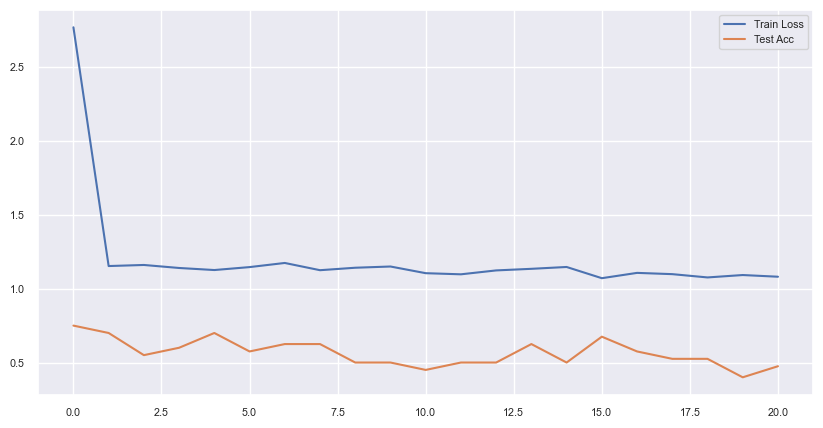

Epoch: 21/30, Train Loss: 1.0808, Test Acc: 0.4750


Train:  75%|█████████████████████████████████████████████████████████                   | 9/12 [00:02<00:00,  6.90it/s]

In [9]:
model = ContrativeModel().to(device)
optim = Adam(model.parameters(), lr = 1e-3)
loss_fn = ContrastiveLoss()
octava(model, train_loader, test_loader, optim, loss_fn, 30, 'stats')